<a href="https://colab.research.google.com/github/s-c-soma/AlternusVera/blob/master/Factor_NewsCoverage_ScoreComputing_wk2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Factor : News Coverage 

by **Subarna Chowdhury Soma** [SJSU ID: 014549587]

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1 Introduction

I will be focusing on the factor **news coverage** to identify  which if a news story is genuine or fake news, as shown below:

| Factor | Score Computation| Explanation|
| -- | -- | -- |
| News Coverage| Coverage of the latent story from outside sources  | Level of coverage regarding the latent story or topic  | 


The news coverage is the factor I put my most personal effort in, covering all areas of distillation (preprocessing, LDA, sentiment analysis)

**Definitions:**
We shall define the  following terms as follows:

>> * **ARTICLE** - a single article printed by one news publication
>> * **STORY** - the underlying event that an article is in reference to
>> * **NEWS COVERAGE**  - number of news from media outlet that covered the same event or latent topic depicted in the article, within a fixed time window. There is a fixed window of time 1 month (coverage 30) and 2 months (coverage 60) before and after the article was published.



## 2 Design Approach

I shall try all the distillation approach on kaggle fake news data set first and then on all news data set. Then I shall perform LDA to to identify topics with score. Next plan is comparing the topic stories between fake news and all news data set. Most important task is computing news coverage score. Final implementation identifying best fit classification model through auto ML. Best performed classification will be applied on fake news dataset, kaggle all news dataset and combined data set after amalgamation. 

Main purpose of using Kaggle fake news dataset and All news data set is that both have news publishing date in data. I need this time information to compare topics/story between two datasets withing same time frame.

* Remaining part: 
> * Amalgamation (partially done)
> * Multi class classification 
> * Include liar liar dataset

### 2.1  Scope

The goal is to create approximate scores for news coverage.

To summarize the document sections will focus on:

1. Introduction
2. Design Approaches
3. Kaggle fake news and Kaggle all news data loading and preparation
4. Trying different distillation approaches on fake news data
5. LDA topic modeling on fake news data
6. Data enrichment by using kaggle all news data set and different exploratory analysis
7. Applying distillation approaches and cleaning kaggle all news data
8. LDA topic modeling on kaggle all news data
9. News Coverage score computation comparing computed topics from LDA
10. Building model by applying different classification model
11. Testing score on Non-fake (all news data) and comparison
12. Amalgamation (partially done)


 ### 2.2 News Coverage
 * **Coverage** We first use topic modeling to find the key latent topics. Then we use a separate dataset called "All the news" dataset to see if there are other  articles covering a similar story. It is important to note that we are *not* cross-checking factual claims made in the article, but rather checking to see if a related and latent topic can be found in other news sources. If there are no external coverage for the story/topic, chances are that the article in question is likely a fake news. However, just because there are sufficient coverage during the time frame, it does not necessarily mean that the news is completely reliable.
  


### 2.3 Alternative Methods Tried



As a team we collected financial news data using API from Newyork Times and Reddit News for our first Machine Learning project. At first I tried to use that news collection, but that dataset has only two news source. For news coverage I need a data set with multiple source covering the same story. Later I have found Kaggle "All News" dataset which contains news of various domain from 15 news sources. So I am proceeding with Kaggle dataset for data enrichment and amalgamation.



### 2.4 Results

Finally I have used autoML to try different classification algorithms to compare accuracy. This week my accuracy improved and Random Forest is giving the best accuracy.  Here are the rest of the results: 

Factor | Algorithm | Accuracy
--- | --- | -----
News Coverage | Random Forest  | 93%
News Coverage | Logistic Regression  | 91%
News Coverage | Linear Discriminant Analysis​(LDA) | 83%



## 3 Data Preprataions


### 3.1 Import Libraries

In [73]:
# For caculating approximate time to process notebook (IGNORE)
import datetime
datetime.datetime.now()

datetime.datetime(2020, 4, 29, 2, 22, 55, 702153)

In [74]:
import argparse
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import nltk as nl
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import ParameterGrid
import statistics
import random
import warnings
from string import punctuation
from matplotlib import pyplot
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
import nltk
import re
import io
import requests
import time
import gensim
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import nltk.sentiment

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### 3.2 Data Load: Kaggle fake news Dataset

For the purpose of this study, we will focus on the Kaggle's Liar Dataset. The main benefit of Kaggle's Liar Dataset is the text entry that is included with the headline. For simplicity and efficiency of colab run time, I am deadling with 1000 rows now. Later I shall use all the rows from dataset.

https://github.com/synle/machine-learning-sample-dataset/raw/master/liar_dataset/kaggle

In [0]:
def get_parsed_data(url, sep='\t', header=None ):
  return pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')), sep=sep, header=header )

# Download and parse the dataset... Let us first work with 100 articles
KAGGLE_DATASET = 'https://github.com/synle/machine-learning-sample-dataset/raw/master/liar_dataset/kaggle'
data_liar_liar = get_parsed_data('%s/kaggle-fake.csv'% KAGGLE_DATASET, ',' , 'infer' )[:1000]

In [76]:
data_liar_liar.head(1)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias



Type counts in Kaggle fake news  Dataset:
bs            718
conspiracy    214
bias           53
fake           15
Name: type, dtype: int64


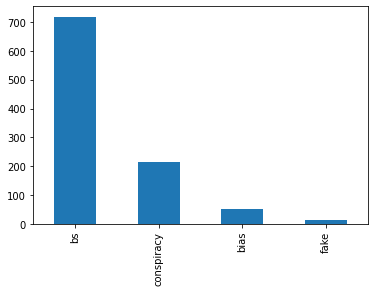

In [77]:
print("\nType counts in Kaggle fake news  Dataset:")
s= data_liar_liar['type'].value_counts()
print(s)
s.plot(kind='bar')

In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

### 3.3 Data Load: Kaggle All News Dataset

We have use two main datasets to be used for data enrichment:

**Dataset 1** - All The News (Thompson, 2017)
- Original: https://www.kaggle.com/snapcrack/all-the-news
- Github Link: https://github.com/hyunwookshin/all_news_dataset_kaggle

The above data is useful for analyzing coverage report of non-fake news articles
curated from mainstream news media sites.



In [0]:
# All News Kaggle

def get_parsed_data2(url):
    return pd.read_csv(io.StringIO(requests.get(url, verify=False).content.decode('utf-8')), sep=',', header='infer')

# download and parse the dataset from github
#data_all_news = get_parsed_data2('https://media.githubusercontent.com/media/hyunwookshin/all_news_dataset_kaggle/master/articles1.csv')

In [80]:
data_all_news = pd.read_csv('/content/drive/My Drive/Colab Notebooks/articles1.csv', low_memory =False, encoding = 'utf-8')
data_all_news.head(5)

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


Word Cloud for All News Dataset


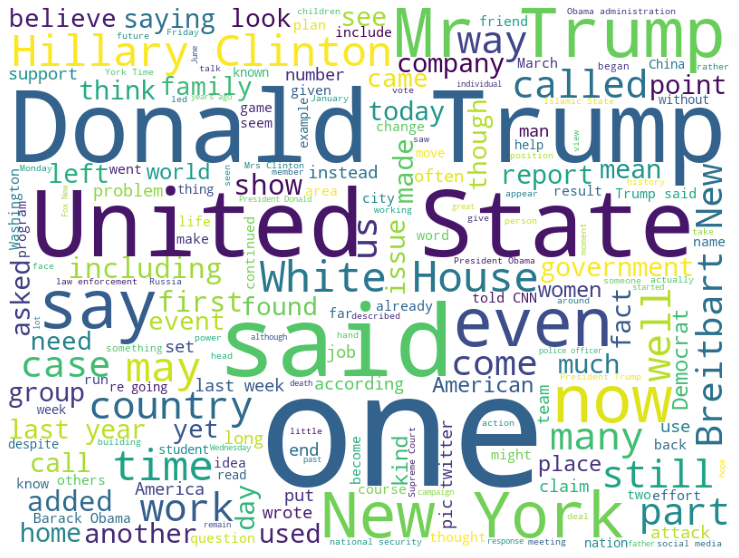

In [81]:
print("Word Cloud for All News Dataset")
    
cloud(' '.join(data_all_news['content']))

## 4 Distillation - Kaggle Fake News Data

### 4.1 Tokenization

As part of the distillation, we tokenize the headline and the body of the articles, by the following methods. First the words are split based on the white space. We also use this step to combine the title with the body of the article.





In [82]:
data_liar_liar['text_distilled'] = data_liar_liar['title'].apply(lambda x : re.split('\W+', str(x).lower())) +\
   data_liar_liar['text'].apply(lambda x : re.split('\W+', str(x).lower()))
data_liar_liar.head(1)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,text_distilled
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,"[muslims, busted, they, stole, millions, in, g..."


In [83]:
data_liar_liar.text_distilled[0][:25]

['muslims',
 'busted',
 'they',
 'stole',
 'millions',
 'in',
 'gov',
 't',
 'benefits',
 'print',
 'they',
 'should',
 'pay',
 'all',
 'the',
 'back',
 'all',
 'the',
 'money',
 'plus',
 'interest',
 'the',
 'entire',
 'family',
 'and']

### 4.2 Lemmatization
  
First, the raw words must be converted to root forms.  

In [84]:
def lemmatize(tokenized_words):
  text = [nltk.WordNetLemmatizer().lemmatize(word) for word in tokenized_words]
  return text

# Commented out per rationale above
#def stemming(tokenized_words):
#  text = [nltk.PorterStemmer().stem(word) for word in tokenized_words]
#  return text

data_liar_liar['text_distilled_lemma'] = data_liar_liar['text_distilled'].apply(lemmatize)
data_liar_liar.text_distilled[0][:15]

['muslims',
 'busted',
 'they',
 'stole',
 'millions',
 'in',
 'gov',
 't',
 'benefits',
 'print',
 'they',
 'should',
 'pay',
 'all',
 'the']

### 4.3 Removing Stop words



In [85]:
english_stopwords = set(stopwords.words('english') + list(punctuation) + [''])

def remove_stopwords(tokenized_words):
  text = [word for word in tokenized_words if word not in english_stopwords]
  return text

data_liar_liar['text_distilled'] = data_liar_liar['text_distilled'].apply(remove_stopwords)
data_liar_liar.text_distilled[0][:15]

['muslims',
 'busted',
 'stole',
 'millions',
 'gov',
 'benefits',
 'print',
 'pay',
 'back',
 'money',
 'plus',
 'interest',
 'entire',
 'family',
 'everyone']

### 4.4 Custom Filtering

Some of the one or two-letter words from the tokenized words are also removed to further cleanse the raw text. 

In [0]:
whitelist = set(['ai', 'ax', 'ca', 'eu', 'go', 'io', 'la', 'ox', 'us', 'uk', 
                 'al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 
                 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi',
                 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny',
                 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn',
                 'tx', 'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy' ])
def remove_too_short(tokenized_words):
  text = [word for word in tokenized_words if (len(word) >= 3 or word not in whitelist) ]
  return text

In [87]:
data_liar_liar['text_distilled'] = data_liar_liar['text_distilled'].apply(remove_too_short)
data_liar_liar.text_distilled[0][:15]

['muslims',
 'busted',
 'stole',
 'millions',
 'gov',
 'benefits',
 'print',
 'pay',
 'back',
 'money',
 'plus',
 'interest',
 'entire',
 'family',
 'everyone']

## 5 Topic Modeling - Kaggle Fake News Data

### 5.1 LDA Analysis


In [0]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

def topics(tokenized_words):
    d = Dictionary([tokenized_words])
    c = [d.doc2bow(tokenized_words)]
    m = LdaModel(c, num_topics=1, id2word=d)
    return list(m.print_topics(num_words=2))
  
data_liar_liar['topics'] = data_liar_liar['text_distilled'].apply(topics)


The topics of some sample articles:

In [89]:
data_liar_liar.title[7],data_liar_liar.topics[7]

('WOW! WHISTLEBLOWER TELLS CHILLING STORY Of Massive Voter Fraud: Trump Campaign Readies Lawsuit Against FL Sec Of Elections In Critical District [VIDEO] » 100percentfedUp.com',
 [(0, '0.015*"elections" + 0.013*"ballots"')])

In [90]:
data_liar_liar.title[2],data_liar_liar.topics[2]

('BREAKING: Weiner Cooperating With FBI On Hillary Email Investigation',
 [(0, '0.029*"weiner" + 0.017*"breaking"')])

In [91]:
data_liar_liar.title[4],data_liar_liar.topics[4]

("FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Healthcare Begins With A Bombshell! » 100percentfedUp.com",
 [(0, '0.022*"insurance" + 0.016*"must"')])

In [92]:
len(data_liar_liar.title)

1000

### 5.2 Topics as Simple List of Words

A list of topic terms is compiled as show below. The coefficients in front of each word are dropped as part of simplification. The assumption is that the top two words comprising the topic, are both significant enough to be treated equally. It is important that the goal is to build a reliable prediction model. While there is a risk of oversimplification, if the final model results in a poor accuracy score, the coefficient can always be reintroduced here.

In [0]:
def parseTopics(topics):
   output = []
   words = topics[0][1].split( '+' )
   for word in words:
       output.append( word.split('*')[1].replace( '"', '' ) )
   return output

data_liar_liar['topics'] = data_liar_liar['topics'].apply(parseTopics)

In [94]:
data_liar_liar.title[1],data_liar_liar.topics[1]

('Re: Why Did Attorney General Loretta Lynch Plead The Fifth?',
 ['lynch ', 'attorney'])



## 6 Data Enrichment and Visual Analysis

The notebook uses Kaggle's "All the news" dataset to curate reference articles to enrich the study of coverage analysis  (Thompson,  2017).



Since "articles1.csv" was sufficient to get a good coverage analysis. The data from articles2.csv and articles3.csv were dropped. Including all data unnecesarily, can result in slow distillation, training and testing.

In [0]:
#data_all_news = pd.read_csv('/content/drive/My Drive/Colab Notebooks/articles1.csv', low_memory =False, encoding = "ISO-8859-1")
#data_all_news.head(20)

### 6.1 Article Count by News Sources


Article counts by publisher:
Breitbart           23781
CNN                 11488
New York Times       7803
Business Insider     6757
Atlantic              171
Name: publication, dtype: int64


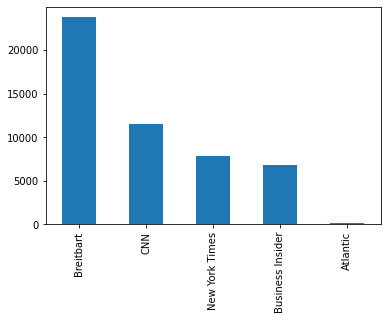

In [96]:
print("\nArticle counts by publisher:")
s= data_all_news['publication'].value_counts()
print(s)
s.plot(kind='bar')

### 6.2 Article Count by Date


Article counts by date:
2016-08-22    221
2017-04-13    187
2017-04-14    180
2017-02-03    172
2017-04-07    169
             ... 
2014-08-25      1
2014-10-24      1
2013-10-17      1
2011-11-22      1
2014-08-06      1
Name: date, Length: 983, dtype: int64


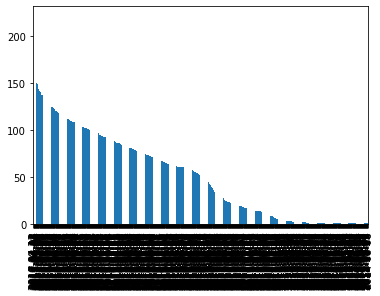

In [97]:
print("\nArticle counts by date:")
s= data_all_news['date'].value_counts()
print(s)
s.plot(kind='bar')

## 7 Distillation - Kaggle All News Dataset

### 7.1 Cleansing "All News" Articles and Finding Document Similarity

For each article, the goal is to count all relevant articles in the data_all_news dataset that contain similar topics. To achieve this, we also need to do a latent topic modelling.



### 7.2 Distillation - Tokenization

In [0]:
data_all_news['text_distilled'] = data_all_news['title'].apply(lambda x : re.split('\W+', str(x).lower())) +\
   data_all_news['content'].apply(lambda x : re.split('\W+', str(x).lower()))

### 7.3 Distillation - Lemmatization

In [0]:
data_all_news['text_distilled'] = data_all_news['text_distilled'].apply(lemmatize)

### 7.4 Distillation - Stop Words

In [0]:
data_all_news['text_distilled'] = data_all_news['text_distilled'].apply(remove_stopwords)

### 7.5 Distillation - Additional

In [101]:
data_all_news['text_distilled'] = data_all_news['text_distilled'].apply(remove_too_short)
data_all_news.text_distilled[0][:15]

['house',
 'republican',
 'fret',
 'winning',
 'health',
 'care',
 'suit',
 'new',
 'york',
 'time',
 'washington',
 'congressional',
 'republican',
 'new',
 'fear']

## 8 Topic Modeling - All News Data

### 8.1 Topic Analysis - Running LDA to Extract Topics

This cell takes time to finish

In [0]:
data_all_news['topics'] = data_all_news['text_distilled'].apply(topics)

In [0]:
data_all_news['topics'] = data_all_news['topics'].apply(parseTopics)

Making sure that the distillation is succesful, the following snippet was run.

In [104]:
data_all_news.title[0], data_all_news.topics[0]

('House Republicans Fret About Winning Their Health Care Suit - The New York Times',
 ['house ', 'republican'])

## 9 News Coverage Computation

### 9.1 Scoring Coverage (Ranking)

The latent topics are parsed from non-fake news datset. To make an appropriate scoring coverage, the latent topics between "all news" data set and fake news dataset (`data_liar_liar`) are compared.

In [0]:
def setDate( published ):
   return published.split( "T" )[0]

data_liar_liar[ 'date' ] = data_liar_liar.published.apply( setDate )

In [106]:
data_liar_liar.head(1)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,text_distilled,text_distilled_lemma,topics,date
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,"[muslims, busted, stole, millions, gov, benefi...","[muslim, busted, they, stole, million, in, gov...","[benefits , government]",2016-10-26


The coverage window is simply a time-range where two articles are considered to be pushed in the same approximate "time frame". Narrowing the window size will result in low coverage score across all rows. Increasing the window size will result in high coverage score across all rows. The choice of the window size was arbitrary (30 days). Please see section 7.17 for 60-day coverage window.

In [0]:
import datetime

def window( datestring, n ):
   d = datetime.datetime.strptime( datestring, "%Y-%m-%d" )
   delta = datetime.timedelta(days=n)
   fromdate = datetime.datetime.strftime(d - delta, "%Y-%m-%d")
   todate = datetime.datetime.strftime(d + delta, "%Y-%m-%d")
   return ( fromdate, todate )

to assign coverage score, the topic “label” for each fake news article is searched in the
“all news” dataset. For each label matches, we increment the coverage score by 1. However, if
the publication dates of the two news articles (one from fake news article, and one from the “all
news” dataset) do not fall in the same time window (30 days or 60 days), no points are awarded
to the coverage score from that particular match. If no news articles match, the coverage score
would be assigned a score of 0 accordingly.

Please note that coverage scoring below can take about 10~15 minutes to complete .

In [108]:
import datetime

print( "Start Time", datetime.datetime.now() )

def coverage( article ):
   fromdate, todate = window( article[ 'date' ], 15 )
   selected_coverage = data_all_news[(data_all_news['date'] > fromdate) & (data_all_news['date'] < todate)]
   selected_coverage['covered'] = selected_coverage.apply( lambda r: r[ 'topics' ][0] in article.topics and
                                                       r[ 'topics' ][1] in article.topics, axis=1 )
   return len(selected_coverage[selected_coverage['covered'] == True])

data_liar_liar[ 'coverage' ] = data_liar_liar.apply( coverage, axis=1 )

print( "Finished Time", datetime.datetime.now() )

Start Time 2020-04-29 02:30:06.755504


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Finished Time 2020-04-29 02:32:09.533638


In [109]:
data_liar_liar.sort_values(by=['coverage'], ascending=False ).head(5)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,text_distilled,text_distilled_lemma,topics,date,coverage
53,a36405a8d7d32c2192b9a9b482dcf0ebc83c62eb,0,Mike Rivero,2016-11-23T00:49:00.000+02:00,FLASHBACK - Hillary Clinton’s ‘KKK’ Smear Agai...,"November 21, 2016 By 21wire Leave a Comment \n...",english,2016-11-23T01:36:58.899+02:00,21stcenturywire.com,US,NaN,FLASHBACK - Hillary Clinton’s ‘KKK’ Smear Agai...,0.0,http://i2.wp.com/21stcenturywire.com/wp-conten...,0,1,0,0,0,conspiracy,"[flashback, hillary, clinton, kkk, smear, trum...","[flashback, hillary, clinton, s, kkk, smear, a...","[mr , trump]",2016-11-23,40
26,c1a86b752a21196a06591d5a785fa29b14fab245,0,EdJenner,2016-11-22T08:17:53.961+02:00,DONALD TRUMP Calls Meeting With Press…Dresses ...,Go to Article \nThey had to know they had it c...,english,2016-11-22T08:17:53.961+02:00,100percentfedup.com,US,25689.0,DONALD TRUMP Calls Meeting With Press…Dresses ...,0.0,http://conservativeangle.com/wp-content/upload...,0,1,0,0,0,bias,"[donald, trump, calls, meeting, press, dresses...","[donald, trump, call, meeting, with, press, dr...","[trump , said]",2016-11-22,23
988,b2e81b8debd3ca29f942d34b781126c07e427194,0,NaN,2016-10-28T18:40:18.626+03:00,"FEAR OF TRUMP: BUSH, OBAMA, CLINTON ALL BUYING...",Email \n\nIt appears Bill and Hillary Clinton ...,english,2016-10-28T18:40:18.626+03:00,awdnews.com,DE,NaN,"FEAR OF TRUMP: BUSH, OBAMA, CLINTON ALL BUYING...",0.0,http://awdnews.com/images/14776680451.jpg,0,0,0,0,0,conspiracy,"[fear, trump, bush, obama, clinton, buying, pr...","[fear, of, trump, bush, obama, clinton, all, b...","[trump , clinton]",2016-10-28,20
980,29aa6e6c0aa6e47a2ee80e18b8ddc031657425b0,0,NaN,2016-10-28T18:34:48.985+03:00,"FEAR OF TRUMP: BUSH, OBAMA, CLINTON ALL BUYING...",Email \n\nIt appears Bill and Hillary Clinton ...,english,2016-10-28T18:34:48.985+03:00,awdnews.com,DE,NaN,"FEAR OF TRUMP: BUSH, OBAMA, CLINTON ALL BUYING...",0.0,http://awdnews.com/images/14776680451.jpg,0,0,0,0,0,conspiracy,"[fear, trump, bush, obama, clinton, buying, pr...","[fear, of, trump, bush, obama, clinton, all, b...","[trump , clinton]",2016-10-28,20
631,7e8e053bbe2ed4978c6b8a69c58fb0441fd4cbf8,0,Alex Ansary,2016-10-31T19:54:37.665+02:00,Get Ready For Civil Unrest,Get Ready For Civil Unrest 10/31/2016 \nECONOM...,english,2016-10-31T19:54:37.665+02:00,amtvmedia.com,US,NaN,Get Ready For Civil Unrest,0.0,http://www.amtvmedia.com/wp-content/uploads/20...,0,1,0,0,0,bs,"[get, ready, civil, unrest, get, ready, civil,...","[get, ready, for, civil, unrest, get, ready, f...","[trump , clinton]",2016-10-31,18


In [110]:
data_liar_liar.sort_values(by=['coverage'], ascending=False ).head(1)['title'], data_liar_liar.sort_values(by=['coverage'], ascending=False ).head(1)['coverage']

(53    FLASHBACK - Hillary Clinton’s ‘KKK’ Smear Agai...
 Name: title, dtype: object, 53    40
 Name: coverage, dtype: int64)

### 9.2 Intermediary Analysis

**Label Pairing** - For now,  top two words of the topics are chosen in the all-news dataset, as "labels." Then using the topics of each fake news datasets and number all-news articles corresponding to each fake news article can be deduced. This means that for every article, we are searching for related articles. 

**Building a Model** This "search" part should only be done during training stage, but not during testing and validation stages. But manually searching each row in the database is expensive and unscalable. Also, if the model simply looks up in internal database and return the score, it is more or less a search solution, not a Machine Learning Classification solution.

Instead of doing this search for every article, the model should predict how much coverage it is likely to have based on the top two **topic terms** and the **date** of publication with classifiers such as Naive Bayes or Decision Trees. Clearly it will require lot of articles for training since there will be a rich set of topic terms and dates resulting in wide range of coverage scores.



### 9.3 Using word2vec to Convert Topics to Vector Embeddings

We use word2vec to fit the entire text from all articles, and then use word2vec model to convert the topic words to vectors.

In [0]:
from gensim.models import Word2Vec

m = Word2Vec( data_liar_liar[ 'text_distilled' ] )

In [112]:
m.similarity( 'clinton', 'hillary' )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.95791185

In [113]:
m.similarity( 'trump', 'election' )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.9302806

In [114]:
import numpy as np

def encodeFirstColumn( topics ):
   topic = topics[0].strip()
   if topic in m:
      return m[topic].tolist()
   else:
      return np.zeros( len(m[list(m.wv.vocab)[0]]) ).tolist()
   
data_liar_liar[ 'topic_0' ] = data_liar_liar.topics.apply( encodeFirstColumn )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Running few sanity check, to ensure that the computation is correct,

In [115]:
'clinton' in m

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """Entry point for launching an IPython kernel.


True

In [116]:
m['hillary']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-1.1261257 , -0.35565618,  0.5308934 ,  0.31250933, -0.51599723,
        0.85071284, -0.44532612, -0.41043127,  0.5270171 ,  0.80782944,
        0.01109449, -0.10405627, -1.5395069 ,  0.15028901, -0.5397747 ,
       -1.0727738 ,  0.5609947 ,  1.4512805 ,  0.23352672, -0.7118468 ,
        0.5341025 , -0.08243874, -0.95022446, -0.18950377,  0.82221574,
       -0.3446628 ,  0.21915431,  0.18560027, -0.38071972, -0.18173261,
       -0.5402041 , -0.11209082,  0.16227743,  0.38868746,  0.43486238,
       -0.54434854, -0.7522533 , -1.0467277 ,  0.17800063, -0.15784808,
        0.2637512 ,  0.31013876,  0.03286861, -0.8035371 , -0.22603652,
        0.74171484, -0.03093684,  0.20788617, -0.03707965,  0.10677567,
        1.3321406 , -0.10934391, -0.764769  , -0.69316393,  0.05324098,
        0.03468162, -0.19551815,  0.34509927,  0.33500278,  0.23473153,
       -0.6253675 ,  0.3148145 ,  0.11992403, -0.5186125 ,  1.0868767 ,
       -0.9952312 ,  0.4375032 ,  1.3114163 ,  0.53884983, -0.67

In [117]:
data_liar_liar[ 'topic_0' ][:10]

0    [-0.07100573927164078, -0.07018429785966873, 0...
1    [-0.10743573307991028, -0.08097492158412933, 0...
2    [-0.19872087240219116, -0.13116684556007385, 0...
3    [-0.18872323632240295, -0.13771241903305054, 0...
4    [-0.08861023932695389, -0.08427300304174423, 0...
5    [-1.1486903429031372, -0.35401153564453125, 0....
6    [-0.08737717568874359, -0.07222270220518112, 0...
7    [-0.23624739050865173, -0.1609201282262802, 0....
8    [-1.1486903429031372, -0.35401153564453125, 0....
9    [-0.9987531304359436, -0.4653044641017914, 0.3...
Name: topic_0, dtype: object

In [118]:
def assertDim( topic_vec ):
   assert len(topic_vec) == len(m[list(m.wv.vocab)[0]]) and len(topic_vec) > 0
    
def assertType( topic_vec ):
   assert isinstance(topic_vec, list)
    
data_liar_liar.topic_0.apply( assertDim )[0]
data_liar_liar.topic_0.apply( assertType )[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


The second topic term is also encoded into word2vec vector.

In [119]:
import numpy as np

vector_dim = len(m[list(m.wv.vocab)[0]])

def encodeSecondColumn( topics ):

   if len( topics ) > 1 :
      topic = topics[1].strip()
   else:
      return np.zeros( len(m[list(m.wv.vocab)[0]]) ).tolist()
   if topic in m:
      return m[topic].tolist()
   else:
      return np.zeros( len(m[list(m.wv.vocab)[0]]) ).tolist()
   
data_liar_liar[ 'topic_1' ] = data_liar_liar.topics.apply( encodeSecondColumn )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarn

In [120]:
data_liar_liar.topic_1.apply( assertDim )[0]
data_liar_liar.topic_1.apply( assertType )[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


### 9.4 Sentiment Analysis

Sentiment analysis has been done on the Kaggle data set

In [121]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def getSentiment( text ):
    return sia.polarity_scores(text)
  
data_liar_liar[ 'text_distilled_joined' ] = data_liar_liar[ 'text_distilled' ].apply( lambda x : ' '.join(x) ) 
data_liar_liar[ 'sentiment' ] = data_liar_liar.text_distilled_joined.apply( getSentiment )

print(data_liar_liar['sentiment' ][:10] )

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
0    {'neg': 0.135, 'neu': 0.669, 'pos': 0.196, 'co...
1    {'neg': 0.129, 'neu': 0.815, 'pos': 0.057, 'co...
2    {'neg': 0.051, 'neu': 0.791, 'pos': 0.158, 'co...
3    {'neg': 0.3, 'neu': 0.46, 'pos': 0.24, 'compou...
4    {'neg': 0.093, 'neu': 0.722, 'pos': 0.185, 'co...
5    {'neg': 0.356, 'neu': 0.591, 'pos': 0.053, 'co...
6    {'neg': 0.135, 'neu': 0.723, 'pos': 0.142, 'co...
7    {'neg': 0.193, 'neu': 0.735, 'pos': 0.072, 'co...
8    {'neg': 0.066, 'neu': 0.842, 'pos': 0.093, 'co...
9    {'neg': 0.152, 'neu': 0.792, 'pos': 0.056, 'co...
Name: sentiment, dtype: object


### 9.5 Converting Dates to Numeric Format

The date column with format YYYY-MM-dd is converted into YYYYMM. Specific day of the months is dropped to avoid overfitting.



In [0]:
def setNumericDate( date ):
   y, m, d = date.split( "-" )
   return int(y + m)

data_liar_liar[ 'date_int' ] = data_liar_liar.date.apply( setNumericDate )

In [123]:
data_liar_liar[ 'date_int' ][0]

201610

## 10 Building Classifier Model

### 10.1 Auto ML

Using the numeric (integer) dates, and two vectors (for top two topics chosen), autoML classifier is trained.

In [124]:
# First split the vectors of word2vec into individual columns

X_prep = data_liar_liar[[ 'date_int', 'topic_0', 'topic_1' ]]

def select(topic_vec, idx):
   return topic_vec[idx]

prep_dict = { "date_int" : [] }
for i in range( vector_dim*2 ):
   prep_dict[str(i)] = []
    
X_COV = pd.DataFrame(prep_dict)
X_COV[ 'date_int' ] = X_prep[ 'date_int' ]

vector_dim = len(m[list(m.wv.vocab)[0]])

for i in range( vector_dim ):
   X_COV[str(i)] = X_prep.topic_0.apply( lambda x : select(x, i ) )
    
X_COV.head(1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


,date_int,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,201610,-0.071006,-0.070184,0.086376,0.058116,-0.150146,0.139081,-0.017385,-0.165807,0.117369,0.103422,0.093982,-0.030602,-0.093256,0.04558,-0.201672,-0.203761,0.033201,0.086438,0.093481,-0.154105,0.246695,0.048686,-0.26842,0.026432,0.142237,-0.114642,-0.023689,-0.081874,0.194523,-0.013514,-0.208827,0.080275,0.034934,0.126227,-0.046466,-0.086509,-0.091696,-0.195525,0.068253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
for i in range( vector_dim ):
   X_COV[str(vector_dim + i)] = X_prep.topic_1.apply( lambda x : select(x, i ) )

In [126]:
X_COV.head(1)

,date_int,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,201610,-0.071006,-0.070184,0.086376,0.058116,-0.150146,0.139081,-0.017385,-0.165807,0.117369,0.103422,0.093982,-0.030602,-0.093256,0.04558,-0.201672,-0.203761,0.033201,0.086438,0.093481,-0.154105,0.246695,0.048686,-0.26842,0.026432,0.142237,-0.114642,-0.023689,-0.081874,0.194523,-0.013514,-0.208827,0.080275,0.034934,0.126227,-0.046466,-0.086509,-0.091696,-0.195525,0.068253,...,0.124339,0.436505,-0.257093,-0.611159,0.737183,-0.054828,0.297687,0.007634,0.101604,-0.306915,0.884227,-0.39626,0.068614,-0.163433,-0.432568,-0.114448,-0.640102,0.202916,-0.429327,-0.659099,0.06316,-0.472955,-0.049513,-0.148252,0.431283,-0.277896,0.16649,-0.365104,-0.343148,-0.015238,-0.493965,-0.533632,0.429865,0.097911,-0.462362,-0.40708,-0.142126,0.363454,-0.673887,0.48983


The following code creates training and test data.

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Y_COV = data_liar_liar[ 'coverage' ]
X_train, X_test, y_train, y_test = train_test_split(X_COV, Y_COV, test_size=0.33, random_state=42)
print("train:" , X_train.shape)
print("test:" , X_test.shape)

train: (670, 201)
test: (330, 201)


In [128]:
X_COV.head(3)

,date_int,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,201610,-0.071006,-0.070184,0.086376,0.058116,-0.150146,0.139081,-0.017385,-0.165807,0.117369,0.103422,0.093982,-0.030602,-0.093256,0.045580,-0.201672,-0.203761,0.033201,0.086438,0.093481,-0.154105,0.246695,0.048686,-0.268420,0.026432,0.142237,-0.114642,-0.023689,-0.081874,0.194523,-0.013514,-0.208827,0.080275,0.034934,0.126227,-0.046466,-0.086509,-0.091696,-0.195525,0.068253,...,0.124339,0.436505,-0.257093,-0.611159,0.737183,-0.054828,0.297687,0.007634,0.101604,-0.306915,0.884227,-0.396260,0.068614,-0.163433,-0.432568,-0.114448,-0.640102,0.202916,-0.429327,-0.659099,0.063160,-0.472955,-0.049513,-0.148252,0.431283,-0.277896,0.166490,-0.365104,-0.343148,-0.015238,-0.493965,-0.533632,0.429865,0.097911,-0.462362,-0.407080,-0.142126,0.363454,-0.673887,0.489830
1,201610,-0.107436,-0.080975,0.108136,0.078631,-0.174732,0.177099,-0.025482,-0.198325,0.134230,0.117814,0.096739,-0.040189,-0.141111,0.065186,-0.235501,-0.238197,0.050175,0.120839,0.099546,-0.192566,0.281994,0.064858,-0.313659,0.026075,0.174340,-0.131654,-0.025209,-0.091071,0.203910,-0.020224,-0.245299,0.080041,0.042549,0.147362,-0.043257,-0.107392,-0.122531,-0.236398,0.079378,...,0.040906,0.301844,-0.140404,-0.478603,0.591652,-0.149238,0.225004,0.141003,0.107574,-0.254313,0.679470,-0.123148,0.041022,-0.196164,-0.251801,-0.001506,-0.459890,0.218565,-0.226319,-0.515185,-0.010779,-0.379338,0.033196,-0.147937,0.364746,-0.172688,0.260913,-0.295923,-0.262781,0.026652,-0.372819,-0.434775,0.333783,0.057717,-0.357500,-0.262213,-0.046576,0.224307,-0.430228,0.339007
2,201610,-0.198721,-0.131167,0.172291,0.120063,-0.265681,0.292400,-0.066294,-0.285398,0.214241,0.192409,0.127977,-0.064162,-0.274384,0.098060,-0.341618,-0.386102,0.088786,0.241966,0.147302,-0.286892,0.408352,0.075864,-0.467117,0.016563,0.277431,-0.208541,-0.034647,-0.103236,0.262756,-0.025793,-0.375781,0.109432,0.054709,0.211747,-0.030426,-0.170047,-0.199728,-0.383141,0.122200,...,0.032792,0.222438,-0.102007,-0.344422,0.438495,-0.107522,0.171188,0.108538,0.081336,-0.183625,0.494135,-0.077531,0.021847,-0.149442,-0.172844,0.000175,-0.339431,0.155594,-0.162563,-0.383943,-0.012437,-0.288310,0.027344,-0.121626,0.259019,-0.122491,0.195249,-0.217251,-0.190340,0.003606,-0.272265,-0.312473,0.249844,0.048090,-0.261719,-0.183869,-0.044858,0.157965,-0.309565,0.249960


In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
num_folds = 10
seed = 7
scoring = 'accuracy'

models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
#models.append(('KNN' , KNeighborsClassifier()))
#models.append(('CART' , DecisionTreeClassifier()))
#models.append(('NB' , GaussianNB()))
#models.append(('SVM' , SVC()))
#models.append(('MNB', MultinomialNB()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
#models.append(('XGBoost', XGBClassifier()))

In [130]:
results = []
names = []

'''
for name, model in models:
  kfold = KFold(n_splits=num_folds, random_state=42)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg) '''

for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    print(name + ": " + str(accu_score))

LR: 0.9121212121212121
LDA: 0.8303030303030303
RF: 0.9393939393939394


### 10.2 Using Ranfom Forrest Classifier

In [0]:
f_cov = RandomForestClassifier(n_estimators=10)
f_cov.fit(X_train, y_train)
y_pred = f_cov.predict(X_test)

Predicting the accuracy of the coverage,

In [132]:
from sklearn import metrics

'Accuracy', metrics.accuracy_score(y_test, y_pred)

('Accuracy', 0.9393939393939394)

The accuracy based on the unseen test data is 90%~95%. This means that using the word2vec-based model one can build a reliable coverage score.

No handles with labels found to put in legend.


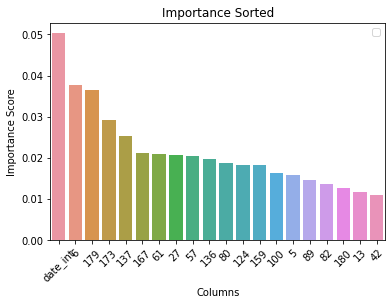

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

importantCols = pd.Series(f_cov.feature_importances_,index=list(X_COV)).sort_values(ascending=False)
sns.barplot(y=importantCols[:20], x=importantCols.index[:20])

plt.ylabel('Importance Score')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.title("Importance Sorted")
plt.legend()
plt.show()

### 10.3 Interpretation

As shown above "`date_int`"  is one of the most important feature in determining whether or not the news has high news coverage. This is expected since the date the news has been posted definitely impacts on whether the news has sufficient coverage from peer articles. Some of the numeric (word2vec) columns  have significant impact on the prediction of the coverage score. But, since these factors are latent, they do not correspond to specific words in the vocabulary.

### 10.4 Other Methods Tried
Also tried using TFIDF as well as shown below.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

ktdv = TfidfVectorizer()
  
data_liar_liar['text_distilled_joined'] = data_liar_liar[ 'text_distilled' ].apply( lambda x :  ' '.join( x ) )
ktdv.fit( data_liar_liar[ 'text_distilled_joined' ])
dim_row = len(ktdv.transform([data_liar_liar[ 'text_distilled_joined' ][0]]).toarray())
dim_col = len(ktdv.transform([data_liar_liar[ 'text_distilled_joined' ][0]]).toarray()[0])
# Eventually dropped

### 10.5 Extension - Increasing the timeframe window to 2 Months

Now that we have coverage of 5 and above for 6/100 articles. We can try and see what values we see if the coverage is increased from 30 days to 60 days

In [135]:
def coverage60( article ):
   fromdate, todate = window( article[ 'date' ], 60 )
   selected_coverage = data_all_news[(data_all_news['date'] > fromdate) & (data_all_news['date'] < todate)]
   selected_coverage['covered'] = selected_coverage.apply( lambda r: r[ 'topics' ][0] in article.topics and
                                                       r[ 'topics' ][1] in article.topics, axis=1 )
   return len(selected_coverage[selected_coverage['covered'] == True])

data_liar_liar[ 'coverage60' ] = data_liar_liar.apply( coverage60, axis=1 )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [136]:
data_liar_liar.sort_values(by=['coverage'], ascending=False ).head(5)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,text_distilled,text_distilled_lemma,topics,date,coverage,topic_0,topic_1,text_distilled_joined,sentiment,date_int,coverage60
53,a36405a8d7d32c2192b9a9b482dcf0ebc83c62eb,0,Mike Rivero,2016-11-23T00:49:00.000+02:00,FLASHBACK - Hillary Clinton’s ‘KKK’ Smear Agai...,"November 21, 2016 By 21wire Leave a Comment \n...",english,2016-11-23T01:36:58.899+02:00,21stcenturywire.com,US,NaN,FLASHBACK - Hillary Clinton’s ‘KKK’ Smear Agai...,0.0,http://i2.wp.com/21stcenturywire.com/wp-conten...,0,1,0,0,0,conspiracy,"[flashback, hillary, clinton, kkk, smear, trum...","[flashback, hillary, clinton, s, kkk, smear, a...","[mr , trump]",2016-11-23,40,"[-0.3587683141231537, -0.2517147660255432, 0.2...","[-0.9987531304359436, -0.4653044641017914, 0.3...",flashback hillary clinton kkk smear trump demo...,"{'neg': 0.141, 'neu': 0.737, 'pos': 0.122, 'co...",201611,117
26,c1a86b752a21196a06591d5a785fa29b14fab245,0,EdJenner,2016-11-22T08:17:53.961+02:00,DONALD TRUMP Calls Meeting With Press…Dresses ...,Go to Article \nThey had to know they had it c...,english,2016-11-22T08:17:53.961+02:00,100percentfedup.com,US,25689.0,DONALD TRUMP Calls Meeting With Press…Dresses ...,0.0,http://conservativeangle.com/wp-content/upload...,0,1,0,0,0,bias,"[donald, trump, calls, meeting, press, dresses...","[donald, trump, call, meeting, with, press, dr...","[trump , said]",2016-11-22,23,"[-0.9987531304359436, -0.4653044641017914, 0.3...","[-0.16590772569179535, -0.20374161005020142, 0...",donald trump calls meeting press dresses real ...,"{'neg': 0.217, 'neu': 0.719, 'pos': 0.064, 'co...",201611,64
988,b2e81b8debd3ca29f942d34b781126c07e427194,0,NaN,2016-10-28T18:40:18.626+03:00,"FEAR OF TRUMP: BUSH, OBAMA, CLINTON ALL BUYING...",Email \n\nIt appears Bill and Hillary Clinton ...,english,2016-10-28T18:40:18.626+03:00,awdnews.com,DE,NaN,"FEAR OF TRUMP: BUSH, OBAMA, CLINTON ALL BUYING...",0.0,http://awdnews.com/images/14776680451.jpg,0,0,0,0,0,conspiracy,"[fear, trump, bush, obama, clinton, buying, pr...","[fear, of, trump, bush, obama, clinton, all, b...","[trump , clinton]",2016-10-28,20,"[-0.9987531304359436, -0.4653044641017914, 0.3...","[-1.1486903429031372, -0.35401153564453125, 0....",fear trump bush obama clinton buying property ...,"{'neg': 0.107, 'neu': 0.745, 'pos': 0.148, 'co...",201610,96
980,29aa6e6c0aa6e47a2ee80e18b8ddc031657425b0,0,NaN,2016-10-28T18:34:48.985+03:00,"FEAR OF TRUMP: BUSH, OBAMA, CLINTON ALL BUYING...",Email \n\nIt appears Bill and Hillary Clinton ...,english,2016-10-28T18:34:48.985+03:00,awdnews.com,DE,NaN,"FEAR OF TRUMP: BUSH, OBAMA, CLINTON ALL BUYING...",0.0,http://awdnews.com/images/14776680451.jpg,0,0,0,0,0,conspiracy,"[fear, trump, bush, obama, clinton, buying, pr...","[fear, of, trump, bush, obama, clinton, all, b...","[trump , clinton]",2016-10-28,20,"[-0.9987531304359436, -0.4653044641017914, 0.3...","[-1.1486903429031372, -0.35401153564453125, 0....",fear trump bush obama clinton buying property ...,"{'neg': 0.107, 'neu': 0.745, 'pos': 0.148, 'co...",201610,96
631,7e8e053bbe2ed4978c6b8a69c58fb0441fd4cbf8,0,Alex Ansary,2016-10-31T19:54:37.665+02:00,Get Ready For Civil Unrest,Get Ready For Civil Unrest 10/31/2016 \nECONOM...,english,2016-10-31T19:54:37.665+02:00,amtvmedia.com,US,NaN,Get Ready For Civil Unrest,0.0,http://www.amtvmedia.com/wp-content/uploads/20...,0,1,0,0,0,bs,"[get, ready, civil, unrest, get, ready, civil,...","[get, ready, for, civil, unrest, get, ready, f...","[trump , clinton]",2016-10-31,18,"[-0.9987531304359436, -0.4653044641017914, 0.3...","[-1.1486903429031372, -0.35401153564453125, 0....",get ready civil unrest get ready civil unrest ...,"{'neg': 0.171, 'neu': 0.686, 'pos': 0.143, 'co...",201610,94


Counting number of articles with coverage scores above 1

In [137]:
len(data_liar_liar[data_liar_liar['coverage60']>1])

95

## 11 Testing on Non-Fake News

The coverage scores (with window = 60 days) are compared between fake news dataset and "All news" non-fake news dataset. Since window of 60 days are chosen for fake news dataset, the same window is chosen for non-fake datasets for consistency.

In [138]:
non_fake_data = data_all_news[:100]

non_fake_data[ 'coverage60' ] = non_fake_data.apply( coverage60, axis=1 )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [139]:
non_fake_data.sort_values(by=['coverage60'], ascending=False ).head(5)

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,text_distilled,topics,coverage60
93,93,17392,Trump Takes on Democrats and Health Law in New...,New York Times,Julie Hirschfeld Davis,2017-01-06,2017.0,1.0,NaN,WASHINGTON — Donald J. Trump lashed out a...,"[trump, take, democrat, health, law, new, twit...","[mr , trump]",155
43,43,17334,Trump Appears to Side With Assange Over Intell...,New York Times,"Scott Shane, Maggie Haberman and Julie Hirschf...",2017-01-05,2017.0,1.0,NaN,■ Donald J. Trump appears to side with the W...,"[trump, appears, side, assange, intelligence, ...","[mr , trump]",155
12,12,17295,"Mar-a-Lago, the Future Winter White House and ...",New York Times,Maggie Haberman,2017-01-02,2017.0,1.0,NaN,"WEST PALM BEACH, Fla. — When Donald J. Tr...","[mar, lago, future, winter, white, house, home...","[mr , trump]",152
77,77,17373,"Enough With the Tweets, China’s State Media Te...",New York Times,Chris Buckley,2017-01-05,2017.0,1.0,NaN,BEIJING — China’s leaders thought they had ...,"[enough, tweet, china, state, medium, tell, tr...","[trump , mr]",74
10,10,17293,Weak Federal Powers Could Limit Trump’s Climat...,New York Times,Justin Gillis,2017-01-03,2017.0,1.0,NaN,With Donald J. Trump about to take control of ...,"[weak, federal, power, could, limit, trump, cl...","[trump , mr]",74


Counting the number of articles with coverage score greater than 1,

In [140]:
len(non_fake_data[non_fake_data['coverage60']>1])

30

### 11.1 Comparisons between Fake and Non-Fake News Datasets

Based on sample of 100 articles from pool of fake and non-fake news sources, the coverage score for non-fake news articles are significantly higher than the fake news articles. In particular, around 30 out of 100 of non-fake news articles had coverage score greater than one. On the other hand, only 14 out of 100 of fake news articles had coverge score greater than one. 


In [141]:
# For caculating approximate time to process notebook (IGNORE)
import datetime
datetime.datetime.now()

datetime.datetime(2020, 4, 29, 2, 42, 40, 798704)

In [153]:
all_data.text_clean.head(2)

0    [print, pay, back, money, plus, interest, enti...
1    [attorney, general, loretta, lynch, plead, fif...
Name: text_clean, dtype: object

In [154]:
all_data.type.value_counts()

0    51507
1    11492
Name: type, dtype: int64

0    51507
1    11492
Name: type, dtype: int64


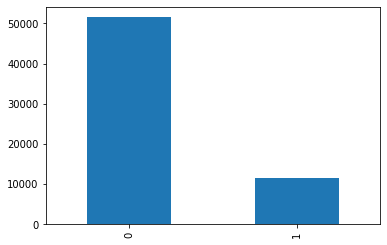

In [155]:

s= all_data['type'].value_counts()
print(s)
s.plot(kind='bar')

## **Reference**

* 1. https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
* 2. https://github.com/hyunwookshin/all_news_dataset_kaggle